In [22]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker  # Import ticker from matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import os
import string

import torch
import torch.nn as nn
import joblib

In [23]:
class MonteCarloDropout(nn.Dropout):
    def forward(self, input):
        return nn.functional.dropout(input, self.p, True, self.inplace)

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, 2056),
            nn.ReLU(),
            #MonteCarloDropout(0.2),
            nn.Linear(2056, 1024),
            nn.ReLU(),
            #MonteCarloDropout(0.2), 
	        nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            MonteCarloDropout(0.2), 
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x)

In [24]:
#mid = "100pct_3day-removed" #potential
mid = "xy-cond-3day" #conducvity
#mid = "current-3day" #current
path = f"/home/sachin/Documents/NIPR/Research/Data/ML/MLP/{mid}_outputs"

In [25]:
model = MLP(10)
model.load_state_dict(torch.load(f'{path}/model_{mid}.pt'))
model.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=2056, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2056, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): MonteCarloDropout(p=0.2, inplace=False)
    (11): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [26]:
y_df = pd.read_csv(f'{path}/y_df_{mid}.csv')
y_test = y_df.pop('y_test')
y_pred = y_df.pop('y_pred')
y_df

,mlt,lon,lat,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,mlt_sin,mlt_cos,lon_sin,lon_cos
0,0.757096,0.746835,0.586207,0.491810,0.512523,0.158845,0.061290,0.863144,0.000000,0.492146,0.000000,0.483420
1,0.501407,0.493671,0.103448,0.570139,0.445042,0.333935,0.047111,0.251644,0.515573,0.000000,0.524085,0.000346
2,0.284071,0.278481,0.310345,0.535699,0.545850,0.111913,0.071352,0.853342,0.991124,0.404670,0.992500,0.413253
3,0.437484,0.430380,0.862069,0.513650,0.439661,0.061372,0.184174,0.269468,0.707471,0.044768,0.715171,0.048456
4,0.000000,1.000000,0.241379,0.420412,0.552267,0.126354,0.058546,0.032681,0.500106,1.000000,0.491165,0.999924
...,...,...,...,...,...,...,...,...,...,...,...,...
10782715,0.680389,0.670886,0.206897,0.576648,0.571310,0.326715,0.075011,0.937013,0.059110,0.263919,0.063084,0.256259
10782716,0.846587,0.835443,0.413793,0.619908,0.499689,0.557762,0.034609,0.789699,0.071039,0.756893,0.066407,0.749366
10782717,0.514191,0.506329,0.103448,0.598278,0.505278,0.146209,0.043299,0.044199,0.475915,0.000346,0.484427,0.000000
10782718,0.897724,0.886076,0.724138,0.678286,0.523701,0.178700,0.046958,0.701017,0.172635,0.877905,0.165876,0.872133


In [27]:
with open(f'{path}/scaler_{mid}.pkl', 'rb') as f:
    scaler = joblib.load(f)

col_names = y_df.columns
norm_arr = scaler.inverse_transform(y_df)
y_df = pd.DataFrame(norm_arr, columns=col_names)
y_df['y_test'] = y_test
y_df['y_pred'] = y_pred
y_df['y_diff'] = y_df['y_pred'] - y_df['y_test']
y_df

,mlt,lon,lat,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,mlt_sin,mlt_cos,lon_sin,lon_cos,y_test,y_pred,y_diff
0,17.940928,269.113924,73.448276,-0.72,1.29,369.0,4.20,0.414752,-0.999880,-0.015464,-0.999458,-0.032912,7.120410,5.746066,-1.374344
1,11.881857,178.227848,54.137931,3.01,-1.97,466.0,3.27,-0.284014,0.030925,-0.999522,0.048364,-0.998830,4.697668,4.670081,-0.027587
2,6.731646,100.974684,62.413793,1.37,2.90,343.0,4.86,0.403550,0.981711,-0.190375,0.984884,-0.173213,14.433789,17.188768,2.754979
3,10.367089,155.506329,84.482759,0.32,-2.23,315.0,12.26,-0.263646,0.414593,-0.910007,0.430411,-0.902633,1.620354,1.624985,0.004631
4,0.000000,360.000000,59.655172,-4.12,3.21,351.0,4.02,-0.534224,0.000000,1.000000,-0.017452,0.999848,1.670396,2.053111,0.382714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10782715,16.123207,241.848101,58.275862,3.32,4.13,462.0,5.10,0.499162,-0.881700,-0.471811,-0.873331,-0.487127,6.515164,7.239488,0.724323
10782716,20.061603,300.924051,66.551724,5.38,0.67,590.0,2.45,0.330826,-0.857849,0.513901,-0.866687,0.498852,5.869422,7.042407,1.172985
10782717,12.184810,182.772152,54.137931,4.35,0.94,362.0,3.02,-0.521062,-0.048364,-0.998830,-0.030925,-0.999522,2.270740,1.698132,-0.572608
10782718,21.273418,319.101266,78.965517,8.16,1.83,380.0,3.26,0.229488,-0.654724,0.755868,-0.667816,0.744326,3.176256,3.182181,0.005925


In [28]:
mae = np.mean(np.abs(y_df['y_diff']))
rmse = np.sqrt(np.mean(y_df['y_diff'] ** 2))
nrmse = rmse / (np.max(y_df['y_test']) - np.min(y_df['y_test']))
R = np.corrcoef(y_df['y_pred'], y_df['y_test'])[0, 1]

def skill(m, o):
    skill = 1 - (np.sum((m - o)**2) / np.sum((o - np.mean(o))**2))
    return skill             

PE = skill(y_pred, y_test)

print(f"RMSE: {rmse:.2f}")
print(f"NRMSE: {nrmse:.5f}")
print(f"MAE: {mae:.2f}")
#print(f"Mean Abs Err pct: {err_pct:.1f}%")
print(f"Correlation: {R:.2f}")
print(f"Skill: {PE:.2f}")

RMSE: 0.66
NRMSE: 0.01068
MAE: 0.34
Correlation: 0.98
Skill: 0.96


In [29]:
ds_df = y_df.copy()
ds_df['lon'] = ds_df['lon'].round()
ds_df['lat'] = ds_df['lat'].round()
ds_df = ds_df.set_index(['lat', 'lon']) 
ds_df = ds_df.groupby(['lat', 'lon']).mean()
y_ds = ds_df.to_xarray()
y_ds

<xarray.Dataset> Size: 250kB
Dimensions:         (lat: 30, lon: 80)
Coordinates:
  * lat             (lat) float64 240B 50.0 51.0 53.0 54.0 ... 87.0 89.0 90.0
  * lon             (lon) float64 640B 1.0 6.0 10.0 15.0 ... 351.0 355.0 360.0
Data variables: (12/13)
    mlt             (lat, lon) float64 19kB 0.06667 0.3696 0.6726 ... 23.7 0.0
    BY_GSE          (lat, lon) float64 19kB -0.266 -0.1899 ... -0.2039 -0.1955
    BZ_GSE          (lat, lon) float64 19kB 0.2812 0.1611 ... 0.2212 0.2022
    flow_speed      (lat, lon) float64 19kB 431.1 432.2 433.1 ... 431.8 432.6
    proton_density  (lat, lon) float64 19kB 6.299 6.514 6.454 ... 6.368 6.392
    tilt_angle      (lat, lon) float64 19kB -0.005841 -0.001021 ... -0.01133
    ...              ...
    mlt_cos         (lat, lon) float64 19kB 0.9998 0.9953 0.9845 ... 0.9969 1.0
    lon_sin         (lat, lon) float64 19kB 0.0 0.07923 ... -0.09662 -0.01745
    lon_cos         (lat, lon) float64 19kB 1.0 0.9969 0.9874 ... 0.9953 0.9998
    y_test          (lat, lon) float64 19kB 1.517 1.517 1.517 ... 3.397 3.41
    y_pred          (lat, lon) float64 19kB 1.523 1.522 1.523 ... 3.384 3.39
    y_diff          (lat, lon) float64 19kB 0.006308 0.005779 ... -0.01974

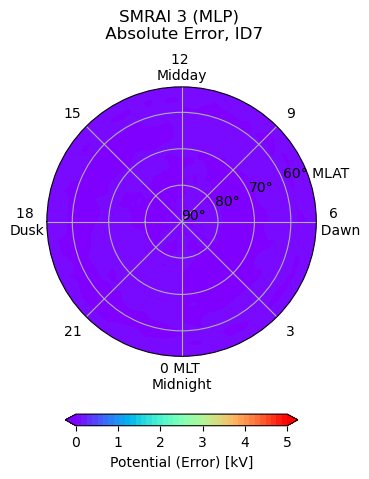

In [20]:
# Define the polar plot parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .5

abs_error = (y_ds['y_diff'].values)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6,5))

c_true = ax.contourf(theta_rad, r, abs_error, levels=np.linspace(0, 5, 40), cmap='rainbow', extend='both')
ax.set_ylim([0, 37])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 \nMidday", "15", "18 \nDusk"])
ax.set_title(f'SMRAI 3 (MLP) \n Absolute Error, ID7', pad=10, fontsize=12)

# Customize colorbar ticks and labels
cb = plt.colorbar(c_true, ax=ax, label='Potential (Error) [kV]', shrink=shrink, pad=0.15, orientation='horizontal')
tick_locator = ticker.MaxNLocator(nbins=6)
cb.locator = tick_locator
cb.update_ticks()

#plt.savefig('MLP_potential_ID7.png', dpi=300, bbox_inches='tight')

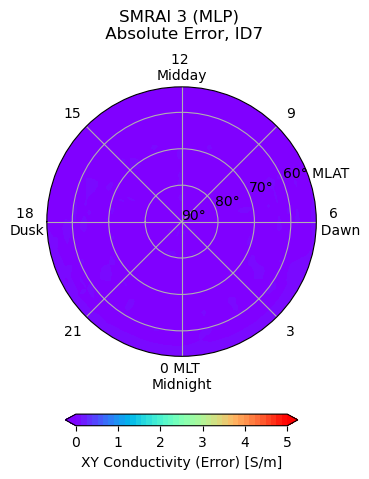

In [30]:
# Define the polar plot parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .5

abs_error = (y_ds['y_diff'].values)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6,5))

c_true = ax.contourf(theta_rad, r, abs_error, levels=np.linspace(0, 5, 40), cmap='rainbow', extend='both')
ax.set_ylim([0, 37])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 \nMidday", "15", "18 \nDusk"])
ax.set_title(f'SMRAI 3 (MLP) \n Absolute Error, ID7', pad=10, fontsize=12)


# Customize colorbar ticks and labels
cb = plt.colorbar(c_true, ax=ax, label='XY Conductivity (Error) [S/m]', shrink=shrink, pad=0.15, orientation='horizontal')
tick_locator = ticker.MaxNLocator(nbins=6)
cb.locator = tick_locator
cb.update_ticks()

# Convert ticks to scientific notation
#ick_values = cb.ax.get_xticks()
#cb.ax.set_xticklabels([f"{tick:.0e}" for tick in tick_values])

plt.savefig('MLP_xy-conductivity_ID7.png', dpi=300, bbox_inches='tight')

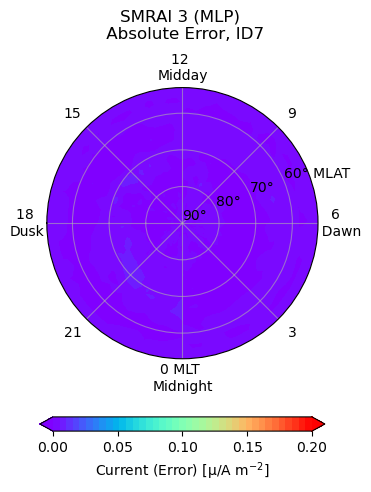

In [21]:
# Define the polar plot parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .5

abs_error = (y_ds['y_diff'].values)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6,5))

c_true = ax.contourf(theta_rad, r, abs_error, levels=np.linspace(0, .2, 40), cmap='rainbow', extend='both')
ax.set_ylim([0, 37])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 \nMidday", "15", "18 \nDusk"])
ax.set_title(f'SMRAI 3 (MLP) \n Absolute Error, ID7', pad=10, fontsize=12)


# Customize colorbar ticks and labels
ma = r'$\mathrm{\mu}$/A m$^{-2}$'
cb = plt.colorbar(c_true, ax=ax, label=f'Current (Error) [{ma}]', shrink=shrink, pad=0.15,
                ticks=np.arange(0,.205,0.05), orientation='horizontal')
#tick_locator = ticker.MaxNLocator(nbins=6)
#cb.locator = tick_locator
#cb.update_ticks()

# Convert ticks to scientific notation
#tick_values = cb.ax.get_xticks()
#cb.ax.set_xticklabels([f"{tick:.0e}" for tick in tick_values])

ax.grid(True, linestyle='-', alpha=0.6)

plt.tight_layout()
plt.savefig('MLP_current_ID7.png', dpi=300, bbox_inches='tight')


In [ ]:
def create_diagonal_ref_plot(df):

    df = df.copy()
    df = df.sample(frac=0.01).reset_index(drop=True)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9.5, 4))
    #plt.figure(figsize=(6, 5))

    y_test = df['y_test'].to_numpy()
    y_true = y_test
    y_pred = df['y_pred'].to_numpy()

    #number of samples
    length =  df.shape[0]

    #y_test = np.asarray(y_true).flatten()
    #y_pred = np.asarray(y_pred).flatten()

    #skewness = stats.skew(y_true)

    mae = np.mean(np.abs(y_test - y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    corr = np.corrcoef(y_test, y_pred)[0,1]
    corr = round(corr, 2)

    def extremes(x, pwr):
        t = np.sum((x - np.mean(x))**pwr)
        b = (len(y_pred)) * (np.std(x))**pwr
        return t / b

    #skew = extremes (m,3) - extremes(o, 3)
    kurt = round(extremes (y_pred,4) - extremes(y_test, 4),2)
    #negative kurtosis (also known as platykurtic) means that the distribution has 
    #thinner tails and a flatter peak compared to a normal distribution.

    #skill score
    def skill(m, o):
        skill = 1 - (np.sum((m - o)**2) / 
                np.sum((o - np.mean(o))**2))

        return skill             

    skill = skill(y_pred, y_test)
    # skill = 1 - (np.sum((y_test - y_pred)**2) / np.sum((np.abs(y_pred - np.mean(y_test)) + np.abs(y_test - np.mean(y_test)))**2))
    skill = round(skill, 2)

    H, xedges, yedges = np.histogram2d(y_true, y_pred, bins=75)     #edges refers to the bin edges
    H = H / np.sum(H) #H is the 2d hist, + normalise by the sum of all bins
    X, Y = np.meshgrid(xedges, yedges) #create rectangular grid from x and y edges

    cont = plt.contourf(X[:-1, :-1], Y[:-1, :-1], H.T, cmap='jet', levels=75)
    #change colorbar ticks
    #plt.scatter(y_true, y_pred, color='black', alpha=0.2)
    #sns.kdeplot(x=y_pred, y=y_true, cmap='jet')

    # Add diagonal line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())    
    plt.plot([min_val, max_val], [min_val, max_val], color='white', linestyle='-', linewidth=.75)

    font_size = 11

    #add info on plot
    n, R, PE = r'$n$', r'$R$', r'$PE$'
    #plt.text(15, -45, f'{n} = {length:,}', color='white', fontsize=font_size)
    #plt.text(-45, 42, f'MAE: {mae:.1f} [m/s]', color='white', fontsize=font_size)
    #plt.text(-45, 34, f'MAE (Rel): {mape:.0f} %', color='white',fontsize=font_size)
    #plt.text(-45, 34, f'MC Error: {mc_test_loss:.1f} [m/s]', color='white', fontsize=font_size)
    #plt.text(-45, 26, f'{R}: {corr} / 1', color='white', fontsize=font_size)
    #plt.text(-45, 19, f'{PE}: {skill} / 1', color='white', fontsize=font_size)

    #set colourbar
    cbar = plt.colorbar(cont,  label='Probability', pad=0.03, aspect=30, format='%.3f')
    cbar.ax.yaxis.set_tick_params(pad=3)
    cbar.set_label(label='Probability', size=11, labelpad=10)

    #add second plot
    hist_df = pd.DataFrame({'y_pred':y_pred, 'y_true':y_true})
    hist_df = pd.melt(hist_df)

    sns.histplot(hist_df, x='value', hue='variable', ax=ax[0], bins=101, 
            palette=['#648FFF','#FE6100'], alpha=0.8, legend=False, kde=True, 
            stat='count', common_norm=False)
    #sns.kdeplot(hist_df, x='value', hue='variable', ax=ax[0], palette=['#648FFF','#FE6100'], alpha=0.8, legend=False)

    ax[0].set_ylabel('Frequency', fontsize=11)
    ax[0].set_xlabel('Potential [kV]', fontsize=11)
    #ax[0].set_xlim([-40, 40])
    ax[0].legend(['Predicted', 'Observed'], loc='upper left', fontsize=font_size)
    
    #ax[0].text(25, 2000, f'Observed:', color='black', fontsize=font_size, weight='bold')
    #ax[0].text(25, 1850, f'Skewness: {skewness:.2f}', color='black', fontsize=font_size)
    mu_lab = r'$\mu$'
    mu = np.mean(y_true)
    #ax[0].text(25, 1700, f'{mu_lab}: {mu:.0f} [m/s]', color='black', fontsize=font_size)
    std_dev_lab = r'$\sigma$'
    std_dev = np.std(y_true)
    #ax[0].text(25, 1550, f'{std_dev_lab}: {std_dev:.0f} [m/s]', color='black', fontsize=font_size)

    #plt.xticks(np.arange(-70, 71, 10))
    #plt.xlim([-70, 70])
    
    #plt.xlabel('Vertical Plasma Drift [m/s]')
    #a.legend()

    #sns.histplot(y_pred, ax=ax[0], color='red', label='Predicted', bins=20)
    #sns.histplot(y_true, ax=ax[0], color='blue', label='Observed', bins=20)

    #add a) and b) labels to subplots using for loop
    for i, letter in enumerate(string.ascii_lowercase[:2]):
        ax[i].text(0.01, 1.05, f'{letter}', transform=ax[i].transAxes, 
                size=20, weight='bold')

    #plt.title('Vertical Plasma Drift, 09-14, ID17b', fontsize=11)
    plt.xlabel('Potential Observed [kV]', fontsize=11)
    plt.ylabel('Potential Predicted [kV]', fontsize=11)
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5)
    
    #increase spacing between subplots


    plt.subplots_adjust(wspace=0.25)  # Adjust horizontal space between subplots 
    #plt.tight_layout()
    
    #plt.savefig(f'09-14_mae_id{model_id}.png', dpi=300)
    #plt.savefig(f'/Users/sr2/OneDrive - University College London/PhD/Research/Missions/P3/TEC-CNOFS/Jan-24/plots/ml/hist/09-14_mae_id{model_id}.png', dpi=400)

    #return hist_df

create_diagonal_ref_plot(y_df)

In [ ]:
tv_curves = pd.read_csv(f'{path}/train-val-curves_{mid}.csv', index_col=0)
tv_curves.rename(columns={'train_losses':'Training Loss', 'val_losses':'Validation Loss'}, inplace=True)

plt.figure(figsize=(5, 3))
sns.lineplot(data=tv_curves, dashes=False, palette=['#648FFF', '#FFB000'])
plt.xlabel('Epochs')
plt.ylabel('Error/Loss [kV]', labelpad=10)
plt.grid(True, linestyle='-', alpha=0.4)
plt.title(f'SMRAI 3 (MLP) \n Training and Validation Curves, ID6', pad=10, fontsize=12)